In [1]:
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt
import pandas as pd
from osc_toolkit import oscillation, delayed_oscillation
from models import *
from functools import partial

import scienceplots

plt.style.use(['science', 'nature'])

Figure 1. Bifurication analysis, role of H2O2 injection

In [2]:
#-------------------Fig 1a
params2 = np.array([22, 3, 0.55, 18, 1e3, 1e3])/0.2
consts2 = [0.11, 2]
init_cond2 = [0, 0, 0, 0]
full_model_4vars_dict = {'model': full_model_4vars, 'calc_all': calc_all_full_model_4vars,
            'info': '6 params: alpha, beta, theta, phi, ep, delta. 2 consts: lam, m, 4 vars: cA2, cS, cO, cM'}

model_std = oscillation(full_model_4vars_dict, params2, consts2, init_cond2)
c_std, t_std = model_std.simulate(calcall=True, t=10)

#--------------------Fig 1b
params = np.array([22, 3, 0.55, 18, 1e3, 1e3])
consts = [0.11, 2]
init_cond = [0, 0, 0, 0]
full_model_4vars_dict = {'model': full_model_4vars, 'calc_all': calc_all_full_model_4vars,
            'info': '6 params: alpha, beta, theta, phi, ep, delta. 2 consts: lam, m, 4 vars: cA2, cS, cO, cM'}

model_osc = oscillation(full_model_4vars_dict, params, consts, init_cond)
c_osc, t_osc = model_osc.simulate(calcall=True, t=5)

#----------------------Fig 1c
params3 = np.array([22, 3, 0.55, 18, 1e3, 1e3])/20
consts3 = [0.11, 2]
init_cond3 = [0, 0, 0, 0]
full_model_4vars_dict = {'model': full_model_4vars, 'calc_all': calc_all_full_model_4vars,
            'info': '6 params: alpha, beta, theta, phi, ep, delta. 2 consts: lam, m, 4 vars: cA2, cS, cO, cM'}

model_std2 = oscillation(full_model_4vars_dict, params3, consts3, init_cond3)
c_std2, t_std2 = model_std2.simulate(calcall=True, t=10)

#----------------------Fig 1d
from sympy import *
import matplotlib.ticker as mticker
cA2, cS, cO, cM = symbols('c_{A_2}, c_{S}, c_{O}, c_{M}')
alpha, beta, theta, phi, delta, ep, lam = symbols('alpha beta theta phi delta epsilon lambda')
m = Rational(2, 1)
cA = 2 * (1 - cA2) - lam * (cS + cM)
dcA2dt = cO * cA - alpha * cM * cA2 - theta * cA2
dcSdt = alpha/lam * cM * cA2 + theta/lam * cA2 - phi * cS - delta * (cS**m - cM)
dcOdt = ep * (1 - cO * cA)
dcMdt = delta * (cS**m - cM) - beta * cM
sol = solve([dcA2dt, dcSdt, dcOdt, dcMdt], (cA2, cS, cO, cM))
cA2_0, cS_0, cO_0, cM_0 = sol[1]
J = Matrix([dcA2dt, dcSdt, dcOdt, dcMdt]).jacobian((cA2, cS, cO, cM))
J0 = J.subs({cA2: cA2_0, cS: cS_0, cO: cO_0, cM: cM_0})
rr = np.concatenate([np.linspace(0.4, 1, 10), np.linspace(1.1, 3, 10)])

rel = []
iml = []
rl = []
for r in rr:
    eimg_c = []
    params = np.array([22, 3, 0.55, 18, 1e3, 1e3])/r
    J0_n = J0.subs({alpha: params[0], beta: params[1], theta: params[2], phi: params[3], delta: params[4], ep: params[5], lam: 0.17})
    e = J0_n.eigenvals()
    eimg = [ei for ei in e if im(ei) != 0]
    for i in eimg:
        for j in eimg:
            if i != j and conjugate(i) == j:
                eimg_c = [i, j]
                rl.append(r)
    rel = rel + [re(e) for e in eimg_c]
    iml = iml + [im(e) for e in eimg_c]

In [3]:
def plot_std(ax):
    name = ['$c_{A_2}$', '$c_{S}$', '$c_{A}$']
    c = ['violet', 'royalblue', 'tomato']
    for i, n in enumerate(name):
        ax.plot(t_std, c_std[i], label=n, c=c[i])
        ax.legend(loc=0)
        ax.set_ylim((-0.1, 4))


def plot_osc(ax):
    name = ['$c_{A_2}$', '$c_{S}$', '$c_{A}$']
    c = ['violet', 'royalblue', 'tomato']
    for i, n in enumerate(name):
        ax.plot(t_osc, c_osc[i], label=n, c=c[i])
        ax.legend(loc=0)
        ax.set_ylim((-0.1, 4))


def plot_std2(ax):
    name = ['$c_{A_2}$', '$c_{S}$', '$c_{A}$']
    c = ['violet', 'royalblue', 'tomato']
    for i, n in enumerate(name):
        ax.plot(t_std2, c_std2[i], label=n, c=c[i])
        ax.legend(loc='right')
        ax.set_ylim((-0.1, 20))


def plot_bfn(ax, fig):
    ax.axhline(0, c='grey')
    ax.axvline(0, c='grey')
    fig.colorbar(ax.scatter(rel, iml, c=rl), ticks=[0.5, 3], format=mticker.FixedFormatter(
        ['Low', 'High']), label='$H_2O_2$ injection rate')
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')

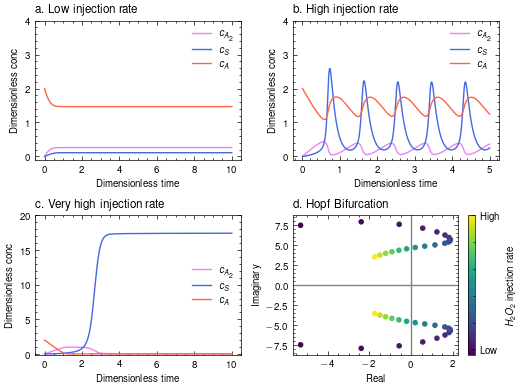

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(16/3, 4))

plot_std(ax[0][0])
plot_osc(ax[0][1])
plot_std2(ax[1][0])
plot_bfn(ax[1][1], fig)

title = ['a. Low injection rate', 'b. High injection rate', 'c. Very high injection rate', 'd. Hopf Bifurcation']
for i, a in enumerate(ax.flatten()):
    a.set_title(title[i], loc='left')
for a in [ax[0][0], ax[0][1], ax[1][0]]:
    a.set_xlabel('Dimensionless time')
    a.set_ylabel('Dimensionless conc')

plt.tight_layout()

fig.savefig('figs/fig1.png', dpi=300)

Figure 2: fitting experimental data

In [2]:
import matplotlib.image as mpimg

In [8]:
files = [r'Data_sets/C82_fig2a_50_Chem_MH.csv', r'Data_sets/C82_fig2a_100_Chem_MH.csv', r'Data_sets/C82_fig2a_200_Chem_MH.csv']

df_MH_Chem_fig2a_50, df_MH_Chem_fig2a_100, df_MH_Chem_fig2a_200 = [pd.read_csv(file) for file in files]
df_list = [df_MH_Chem_fig2a_50, df_MH_Chem_fig2a_100, df_MH_Chem_fig2a_200]

cA2_tol = 14.5
CMC_3a = 1.56
rexts = [7, 14, 28]

for df, rext in zip(df_list, rexts):
    tau = cA2_tol/rext
    df['cS'] /= CMC_3a
    df['tS'] /= tau
    df['tA2'] /= tau

#------------Parameters fitted from experiments--------
rates = [2311.4, 914.9, 16.002, 370.02, 1e4, 1e4]
#------------------------------------------------------
rs_ac, rds_ac, rs, rds, ro, rm = rates
rext = 14
tau = 14.5 / rext
lam, m = 0.11, 2
td1, td2 = 0.02, 0.02

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm / rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0, 0, 0, 0])
delayed_model_100 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_100.add_exp_data(df_MH_Chem_fig2a_100)
delayed_model_100.set_init_cond([0, 0, 0, 0])
c100, t100 = delayed_model_100.simulate(exp=True, calcall=True, acc=200)

c100 = c100 * CMC_3a
t100 = t100 * tau

c100_exp = delayed_model_100._exp_data['cS'] * CMC_3a
t100_exp = delayed_model_100._exp_data['tS'] * tau

#---------------------Testing 1---------------------------------
rs_ac, rds_ac, rs, rds, ro, rm = rates
rext = 7
tau = 14.5 / rext
lam, m = 0.11, 2
td1, td2 = 0.02/2, 0.02/2

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm / rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0, 0, 0, 0])
delayed_model_50 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_50.add_exp_data(df_MH_Chem_fig2a_50)
delayed_model_50.set_init_cond([0, 0, 0, 0])
c50, t50 = delayed_model_50.simulate(exp=True, calcall=True, acc=200)

c50 = c50 * CMC_3a
t50 = t50 * tau

c50_exp = delayed_model_50._exp_data['cS'] * CMC_3a
t50_exp = delayed_model_50._exp_data['tS'] * tau

#-------------------Testing 2------------------------------------
rs_ac, rds_ac, rs, rds, ro, rm = rates
rext = 28
tau = 14.5 / rext
lam, m = 0.11, 2
td1, td2 = 0.02*2, 0.02*2

#Definition of the model
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm / rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0, 0, 0, 0])
delayed_model_200 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_200.add_exp_data(df_MH_Chem_fig2a_200)
delayed_model_200.set_init_cond([0, 0, 0, 0])
c200, t200 = delayed_model_200.simulate(exp=True, calcall=True, acc=200)

c200 = c200 * CMC_3a
t200 = t200 * tau

c200_exp = delayed_model_200._exp_data['cS'] * CMC_3a
t200_exp = delayed_model_200._exp_data['tS'] * tau

The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.         0.01858045]
Initial condition is set as [0, 0, 0, 0]
Generating, compiling, and loading C code.


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.
The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0. 0.]
Initial condition is set as [0, 0, 0, 0]
Generating, compiling, and loading C code.


/Users/zhihengzhang/Documents/01_Research/03_Lab-SPF/Chemical_Oscillation_Model/osc_toolkit.py:289: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  sol = np.array([self.dde.integrate(time) for time in t_eval])
clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.
The species are ['$c_{A_2}$', '$c_S$', '$c_A$', '$c_O$']. Please check if the data is in the same order and correct format (time, concentration).
Initial condition is set as [0.         0.03450656]
Initial condition is set as [0, 0, 0, 0]
Generating, compiling, and loading C code.


clang: warning: argument '-Ofast' is deprecated; use '-O3 -ffast-math' for the same behavior, or '-O3' to enable only conforming optimizations [-Wdeprecated-ofast]
ld: warning: duplicate -rpath '/Users/zhihengzhang/anaconda3/lib' ignored


Using default integration parameters.


In [15]:
def plot_diagram(ax):
    pic = mpimg.imread('fitting.png')
    ax.imshow(pic, aspect = "auto")
    ax.set(xticks=[], yticks=[])

def plot_100(ax):
    ax.plot(t100, c100[1], label='Simulation', c='royalblue')
    ax.plot(t100_exp, c100_exp, marker='.', label='Experiment', c='navy')
    ax.set_ylim([-0.05, 3])
    ax.legend(loc='upper right')

def plot_50(ax):
    ax.plot(t50, c50[1], label='Simulation', c='limegreen')
    ax.plot(t50_exp, c50_exp, marker='.', label='Experiment', c='green')
    ax.set_ylim([-0.05, 3])
    ax.legend(loc='upper right')

def plot_200(ax):
    ax.plot(t200, c200[1], label='Simulation', c='limegreen')
    ax.plot(t200_exp, c200_exp, marker='.', label='Experiment', c='green')
    ax.set_ylim([-0.05, 3])
    ax.legend(loc='upper right')

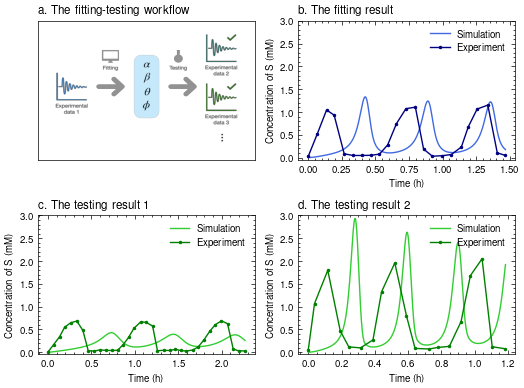

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(16/3, 4))

plot_diagram(ax[0][0])
plot_100(ax[0][1])
plot_50(ax[1][0])
plot_200(ax[1][1])


title = ['a. The fitting-testing workflow', 'b. The fitting result', 'c. The testing result 1', 'd. The testing result 2']
xlabel = ['', 'Time (h)', 'Time (h)', 'Time (h)']
ylabel = ['', 'Concentration of S (mM)', 'Concentration of S (mM)', 'Concentration of S (mM)']

for i, a in enumerate(fig.axes):
    a.set_title(title[i], loc='left')
    a.set_xlabel(xlabel[i])
    a.set_ylabel(ylabel[i])

plt.tight_layout()

plt.savefig('figs/fig2.png', dpi=300)

Figure 3. Spell "OXFORD"

In [20]:
tau1 = 14.5/18.2
tau2 = 14.5/42

rs_ac, rds_ac, rs, rds, ro, rm = rates
rext = 42
lam, m = 0.11, 2
td1, td2 = 0.02*3, 0.02*3

#Definition of the model 300
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm / rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0, 0, 0, 0])
delayed_model_300 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_300.set_init_cond([0, 0, 0, 0])

rs_ac, rds_ac, rs, rds, ro, rm = rates
rext = 18.2
lam, m = 0.11, 2
td1, td2 = 0.02*1.3, 0.02*1.3

#Definition of the model 130
alpha, beta, theta, phi, ep, delta = rs_ac / rext, rds_ac / rext, rs / rext, rds / rext, ro / rext, rm / rext
params = np.array([alpha, beta, theta, phi, ep, delta])
consts = np.array([lam, m])
delay = np.array([td1, td2])
init_cond = np.array([0, 0, 0, 0])
delayed_model_130 = delayed_oscillation(delayed_full_4vars, delay, params, consts, init_cond)
delayed_model_130.set_init_cond([0, 0, 0, 0])

Initial condition is set as [0, 0, 0, 0]
Initial condition is set as [0, 0, 0, 0]


In [ ]:
delayed_model_130.set_init_cond([0, 0, 0, 0])
delayed_model_300.set_init_cond([0, 0, 0, 0])
sol1, t1 = delayed_model_130.simulate(t=1.7, acc=150)

t_O = t1*tau1
c_O = delayed_full_4vars['calc_all'](sol1, delayed_model_130._consts)
cS_O = c_O[1] * CMC_3a

delayed_model_130.set_init_cond([0,0,0,0])
sol2, t2 = delayed_model_130.simulate(t=0.7, acc=150)
delayed_model_300.set_init_cond(sol2[-1])
sol3, t3 = delayed_model_300.simulate(t=1.5, acc=150)
delayed_model_130.set_init_cond(sol3[-1])
sol4, t4 = delayed_model_130.simulate(t=0.5, acc=150)

t_X = np.concatenate((t2*tau1, t3*tau2 + t2[-1]*tau1, t4*tau1 + t3[-1]*tau2 + t2[-1]*tau1))
sol_X = np.concatenate((sol2, sol3, sol4))
c_X = delayed_full_4vars['calc_all'](sol_X, delayed_model_130._consts)
cS_X = c_X[1] * CMC_3a

delayed_model_300.set_init_cond([0,0,0,0])
sol5, t5 = delayed_model_300.simulate(t=1.7, acc=150)
delayed_model_130.set_init_cond(sol5[-1])
sol6, t6 = delayed_model_130.simulate(t=0.5, acc=150)
delayed_model_300.set_init_cond(sol6[-1])
sol7, t7 = delayed_model_300.simulate(t=0.8, acc=150)

t_F = np.concatenate((t5*tau2, t6*tau1 + t5[-1]*tau2, t7*tau2 + t6[-1]*tau1 + t5[-1]*tau2))
sol_F = np.concatenate((sol5, sol6, sol7))
c_F = delayed_full_4vars['calc_all'](sol_F, delayed_model_130._consts)
cS_F = c_F[1] * CMC_3a

delayed_model_300.set_init_cond([0,0,0,0])
sol8, t8 = delayed_model_300.simulate(t=0.8, acc=150)

delayed_model_130.set_init_cond(sol8[-1])
sol9, t9 = delayed_model_130.simulate(t=0.7, acc=150)

delayed_model_300.set_init_cond(sol9[-1])
sol10, t10 = delayed_model_300.simulate(t=0.9, acc=150)

t_R = np.concatenate((t8*tau2, t9*tau1 + t8[-1]*tau2, t10*tau2 + t9[-1]*tau1 + t8[-1]*tau2))
sol_R = np.concatenate((sol8, sol9, sol10))
c_R = delayed_full_4vars['calc_all'](sol_R, delayed_model_130._consts)
cS_R = c_R[1] * CMC_3a

delayed_model_130.set_init_cond([0,0,0,0])
sol11, t11 = delayed_model_130.simulate(t=0.7, acc=150)

delayed_model_300.set_init_cond(sol11[-1])
sol12, t12 = delayed_model_300.simulate(t=1.5, acc=150)

t_D = np.concatenate((t11*tau1, t12*tau2 + t11[-1]*tau1))
sol_D = np.concatenate((sol11, sol12))
c_D = delayed_full_4vars['calc_all'](sol_D, delayed_model_130._consts)
cS_D = c_D[1] * CMC_3a

In [ ]:
def plot_oxford(ax):
    fig, ax = plt.subplots(1, 6, figsize=(12, 2.5), sharey=True)

    xlist = [t_O, t_X, t_F, t_O, t_R, t_D]
    ylist = [cS_O, cS_X, cS_F, cS_O, cS_R, cS_D]
    title_list = ['O', 'X', 'F', 'O', 'R', 'D']

    for i in range(len(xlist)):
        ax[i].plot(xlist[i], ylist[i])
        ax[i].set_title(title_list[i])

    fig.supxlabel('time (h)')
    fig.supylabel('S (mM)')

    plt.tight_layout()

Figure 4. Stirring rate, role of time delays

Figure 5. Sync of 2 oscillators